In [3]:
import polars as pl
import sys
import json
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
import os
from tqdm.notebook import tqdm

In [4]:
PERCENTILES = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

In [30]:
df = pl.scan_csv('/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/train_labels.csv').collect()
df

row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors
i64,str,f64,f64,f64,i64,i64,i64,f64,i64
0,"""tomo_003acc""",-1.0,-1.0,-1.0,500,1912,1847,6.5,0
1,"""tomo_00e047""",169.0,546.0,603.0,300,959,928,15.6,1
2,"""tomo_00e463""",235.0,403.0,137.0,500,924,956,19.7,6
3,"""tomo_00e463""",243.0,363.0,153.0,500,924,956,19.7,6
4,"""tomo_00e463""",222.0,379.0,144.0,500,924,956,19.7,6
…,…,…,…,…,…,…,…,…,…
732,"""tomo_fe050c""",138.0,134.0,542.0,300,959,928,15.6,1
733,"""tomo_fe85f6""",-1.0,-1.0,-1.0,800,928,960,13.1,0
734,"""tomo_fea6e8""",-1.0,-1.0,-1.0,300,960,928,16.8,0


In [31]:
df.describe()

statistic,row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",737.0,"""737""",737.0,737.0,737.0,737.0,737.0,737.0,737.0,737.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",368.0,null,101.861601,294.85346,300.818182,422.651289,950.207598,954.819539,15.341655,1.127544
"""std""",212.897863,null,102.208293,282.325485,293.368799,174.341523,64.861948,97.22997,2.398197,1.642676
"""min""",0.0,"""tomo_003acc""",-1.0,-1.0,-1.0,300.0,924.0,924.0,6.5,0.0
"""25%""",184.0,null,-1.0,-1.0,-1.0,300.0,928.0,928.0,13.1,0.0
"""50%""",368.0,null,106.0,278.0,280.0,300.0,959.0,928.0,15.6,1.0
"""75%""",552.0,null,170.0,549.0,567.0,500.0,960.0,956.0,16.8,1.0
"""max""",736.0,"""tomo_ff7c20""",466.0,904.0,902.0,800.0,1912.0,1847.0,19.7,10.0


In [32]:
tmp = df.select(pl.col('Motor axis 0', 'Motor axis 1', 'Motor axis 2')).to_numpy()
for row in tmp:
    if row[0] ==-1:
        assert row[1] == row[2] == -1
    else:
        if row[0] * row[1] * row[2] == 0:
            print(row)
        assert row[0] >= 0 and row[1] >= 0 and row[2] >= 0, f'{row}'

[  0. 556. 359.]


In [33]:
df = df.with_columns((pl.col('Motor axis 0') >= 0).alias('has_motor'))
df

row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors,has_motor
i64,str,f64,f64,f64,i64,i64,i64,f64,i64,bool
0,"""tomo_003acc""",-1.0,-1.0,-1.0,500,1912,1847,6.5,0,false
1,"""tomo_00e047""",169.0,546.0,603.0,300,959,928,15.6,1,true
2,"""tomo_00e463""",235.0,403.0,137.0,500,924,956,19.7,6,true
3,"""tomo_00e463""",243.0,363.0,153.0,500,924,956,19.7,6,true
4,"""tomo_00e463""",222.0,379.0,144.0,500,924,956,19.7,6,true
…,…,…,…,…,…,…,…,…,…,…
732,"""tomo_fe050c""",138.0,134.0,542.0,300,959,928,15.6,1,true
733,"""tomo_fe85f6""",-1.0,-1.0,-1.0,800,928,960,13.1,0,false
734,"""tomo_fea6e8""",-1.0,-1.0,-1.0,300,960,928,16.8,0,false


In [36]:
(df['has_motor'] == (df['Number of motors'] > 0)).all()

True

In [39]:
df = df.with_columns(pl.len().over('tomo_id').alias('num_motors')).with_columns((pl.col('num_motors') * pl.col('has_motor')).alias('num_motors'))
df

row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors,has_motor,num_motors
i64,str,f64,f64,f64,i64,i64,i64,f64,i64,bool,u32
0,"""tomo_003acc""",-1.0,-1.0,-1.0,500,1912,1847,6.5,0,false,0
1,"""tomo_00e047""",169.0,546.0,603.0,300,959,928,15.6,1,true,1
2,"""tomo_00e463""",235.0,403.0,137.0,500,924,956,19.7,6,true,6
3,"""tomo_00e463""",243.0,363.0,153.0,500,924,956,19.7,6,true,6
4,"""tomo_00e463""",222.0,379.0,144.0,500,924,956,19.7,6,true,6
…,…,…,…,…,…,…,…,…,…,…,…
732,"""tomo_fe050c""",138.0,134.0,542.0,300,959,928,15.6,1,true,1
733,"""tomo_fe85f6""",-1.0,-1.0,-1.0,800,928,960,13.1,0,false,0
734,"""tomo_fea6e8""",-1.0,-1.0,-1.0,300,960,928,16.8,0,false,0


**What TF???**

In [42]:
df.filter(pl.col('Number of motors') != pl.col('num_motors'))

row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors,has_motor,num_motors
i64,str,f64,f64,f64,i64,i64,i64,f64,i64,bool,u32
127,"""tomo_2b3cdf""",134.0,173.0,662.0,300,960,928,13.1,2,true,1
284,"""tomo_62eea8""",111.0,469.0,334.0,300,960,928,13.1,2,true,1
580,"""tomo_c84b8e""",147.0,317.0,681.0,300,960,928,13.1,2,true,1
676,"""tomo_e6f7f7""",180.0,548.0,267.0,300,960,928,13.1,2,true,1


In [44]:
display(df.filter(pl.col('tomo_id') == 'tomo_2b3cdf'))
display(df.filter(pl.col('tomo_id') == 'tomo_62eea8'))
display(df.filter(pl.col('tomo_id') == 'tomo_62eea8'))
display(df.filter(pl.col('tomo_id') == 'tomo_e6f7f7'))

row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors,has_motor,num_motors
i64,str,f64,f64,f64,i64,i64,i64,f64,i64,bool,u32
127,"""tomo_2b3cdf""",134.0,173.0,662.0,300,960,928,13.1,2,true,1


row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors,has_motor,num_motors
i64,str,f64,f64,f64,i64,i64,i64,f64,i64,bool,u32
284,"""tomo_62eea8""",111.0,469.0,334.0,300,960,928,13.1,2,true,1


row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors,has_motor,num_motors
i64,str,f64,f64,f64,i64,i64,i64,f64,i64,bool,u32
284,"""tomo_62eea8""",111.0,469.0,334.0,300,960,928,13.1,2,true,1


row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors,has_motor,num_motors
i64,str,f64,f64,f64,i64,i64,i64,f64,i64,bool,u32
676,"""tomo_e6f7f7""",180.0,548.0,267.0,300,960,928,13.1,2,true,1


In [7]:
df.n_unique('tomo_id')

648

In [8]:
df.filter(~pl.col('has_motor')).group_by('tomo_id').agg(pl.len().alias('num_motors')).group_by('num_motors').len().sort('num_motors')

num_motors,len
u32,u32
1,286


In [9]:
df.filter(pl.col('has_motor')).group_by('tomo_id').agg(pl.len().alias('num_motors')).group_by('num_motors').len().sort('num_motors')

num_motors,len
u32,u32
1,317
2,26
3,6
4,9
6,3
10,1


Number of motors per tomo distribution:
```
0	286
1	317
2	26
3	6
4	9
6	3
10	1
```


In [10]:
286 + 317 + 26 + 6 + 9 + 3 + 1

648

In [11]:
tomo_names = sorted(os.listdir('/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/train'))
len(tomo_names)

648

In [12]:
df

row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors,has_motor
i64,str,f64,f64,f64,i64,i64,i64,f64,i64,bool
0,"""tomo_003acc""",-1.0,-1.0,-1.0,500,1912,1847,6.5,0,false
1,"""tomo_00e047""",169.0,546.0,603.0,300,959,928,15.6,1,true
2,"""tomo_00e463""",235.0,403.0,137.0,500,924,956,19.7,6,true
3,"""tomo_00e463""",243.0,363.0,153.0,500,924,956,19.7,6,true
4,"""tomo_00e463""",222.0,379.0,144.0,500,924,956,19.7,6,true
…,…,…,…,…,…,…,…,…,…,…
732,"""tomo_fe050c""",138.0,134.0,542.0,300,959,928,15.6,1,true
733,"""tomo_fe85f6""",-1.0,-1.0,-1.0,800,928,960,13.1,0,false
734,"""tomo_fea6e8""",-1.0,-1.0,-1.0,300,960,928,16.8,0,false


In [13]:
for i, row in tqdm(enumerate(df.iter_rows(named = True))):
    tomo_id = row['tomo_id']
    Z, Y, X = row['Array shape (axis 0)'], row['Array shape (axis 1)'], row['Array shape (axis 2)']
    # print(Z, Y, X)
    tomo_dir = os.path.join('/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/train/', tomo_id)
    slice_img_names = sorted(os.listdir(tomo_dir))
    assert slice_img_names == [f'slice_{j:04d}.jpg' for j in range(Z)]

    img = cv2.imread(os.path.join('/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/train/', tomo_id, 'slice_0000.jpg'))
    assert img.shape[:2] == (Y, X)

737it [00:21, 35.06it/s]


In [14]:
df = df.with_columns(
    (pl.col('Array shape (axis 0)') * pl.col('Voxel spacing')).alias('ZA'),
    (pl.col('Array shape (axis 1)') * pl.col('Voxel spacing')).alias('YA'),
    (pl.col('Array shape (axis 2)') * pl.col('Voxel spacing')).alias('XA'),
).with_columns(
    (pl.col('Array shape (axis 0)') * pl.col('Array shape (axis 1)') * pl.col('Array shape (axis 2)')).alias('V'),
    (pl.col('ZA') * pl.col('YA') * pl.col('XA')).alias('VA'),
    (pl.col('Array shape (axis 2)') / pl.col('Array shape (axis 1)')).alias('aspect_ratio')
)
df

row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors,has_motor,ZA,YA,XA,V,VA,aspect_ratio
i64,str,f64,f64,f64,i64,i64,i64,f64,i64,bool,f64,f64,f64,i64,f64,f64
0,"""tomo_003acc""",-1.0,-1.0,-1.0,500,1912,1847,6.5,0,false,3250.0,12428.0,12005.5,1765732000,4.8491e11,0.966004
1,"""tomo_00e047""",169.0,546.0,603.0,300,959,928,15.6,1,true,4680.0,14960.4,14476.8,266985600,1.0136e12,0.967675
2,"""tomo_00e463""",235.0,403.0,137.0,500,924,956,19.7,6,true,9850.0,18202.8,18833.2,441672000,3.3767e12,1.034632
3,"""tomo_00e463""",243.0,363.0,153.0,500,924,956,19.7,6,true,9850.0,18202.8,18833.2,441672000,3.3767e12,1.034632
4,"""tomo_00e463""",222.0,379.0,144.0,500,924,956,19.7,6,true,9850.0,18202.8,18833.2,441672000,3.3767e12,1.034632
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
732,"""tomo_fe050c""",138.0,134.0,542.0,300,959,928,15.6,1,true,4680.0,14960.4,14476.8,266985600,1.0136e12,0.967675
733,"""tomo_fe85f6""",-1.0,-1.0,-1.0,800,928,960,13.1,0,false,10480.0,12156.8,12576.0,712704000,1.6022e12,1.034483
734,"""tomo_fea6e8""",-1.0,-1.0,-1.0,300,960,928,16.8,0,false,5040.0,16128.0,15590.4,267264000,1.2673e12,0.966667


### Voxel spacing

(array([  3.,   0.,   0.,   0.,   0., 311., 177., 125.,   0., 121.]),
 array([ 6.5 ,  7.82,  9.14, 10.46, 11.78, 13.1 , 14.42, 15.74, 17.06,
        18.38, 19.7 ]),
 <BarContainer object of 10 artists>)

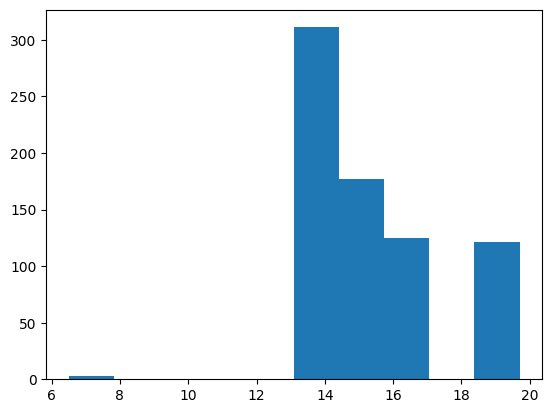

In [15]:
plt.hist(df['Voxel spacing'])

In [16]:
df.group_by('Voxel spacing').len().sort('Voxel spacing')

Voxel spacing,len
f64,u32
6.5,3
13.1,291
13.2,2
13.3,18
15.6,177
16.1,40
16.8,85
19.2,7
19.3,10


### ZYX shape

Array shape (axis 0),len
i64,u32
300,439
400,1
494,1
500,191
600,3
800,102


(array([439.,   0.,   1.,   1., 191.,   0.,   3.,   0.,   0., 102.]),
 array([300., 350., 400., 450., 500., 550., 600., 650., 700., 750., 800.]),
 <BarContainer object of 10 artists>)

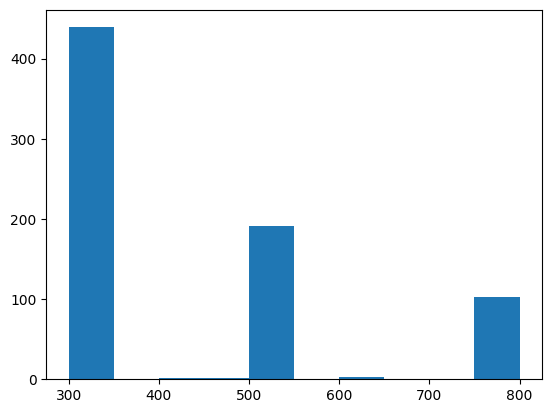

In [17]:
display(df.group_by('Array shape (axis 0)').len().sort('Array shape (axis 0)'))
plt.hist(df['Array shape (axis 0)'])

Array shape (axis 1),len
i64,u32
924,120
927,11
928,202
956,1
959,74
960,308
1024,18
1912,3


(array([716.,  18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([ 924. , 1022.8, 1121.6, 1220.4, 1319.2, 1418. , 1516.8, 1615.6,
        1714.4, 1813.2, 1912. ]),
 <BarContainer object of 10 artists>)

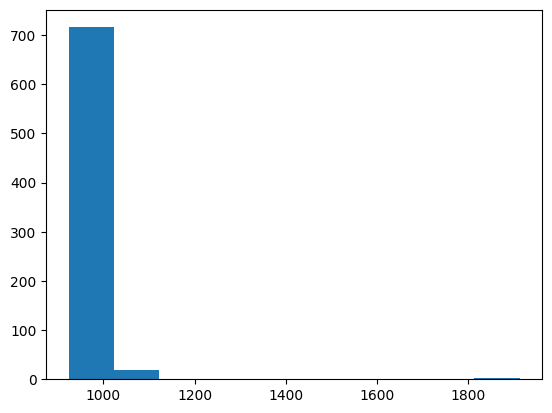

In [18]:
display(df.group_by('Array shape (axis 1)').len().sort('Array shape (axis 1)'))
plt.hist(df['Array shape (axis 1)'])

Array shape (axis 2),len
i64,u32
924,1
928,456
956,120
959,11
960,128
1440,18
1847,3


(array([716.,   0.,   0.,   0.,   0.,  18.,   0.,   0.,   0.,   3.]),
 array([ 924. , 1016.3, 1108.6, 1200.9, 1293.2, 1385.5, 1477.8, 1570.1,
        1662.4, 1754.7, 1847. ]),
 <BarContainer object of 10 artists>)

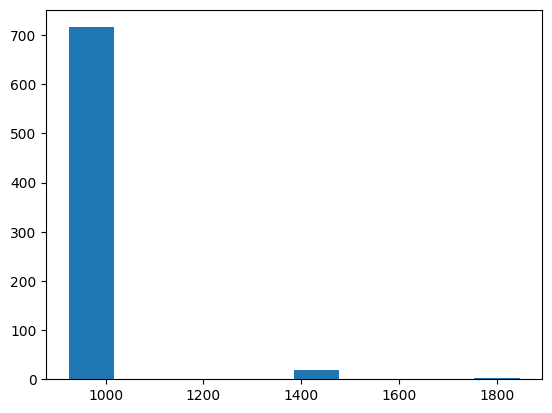

In [19]:
display(df.group_by('Array shape (axis 2)').len().sort('Array shape (axis 2)'))
plt.hist(df['Array shape (axis 2)'])

ZA,len
f64,u32
3211.0,1
3250.0,2
3930.0,171
3960.0,1
4680.0,175
…,…
10480.0,72
10560.0,1
11580.0,1


(array([175., 256.,  78.,  16.,   6., 175.,   2.,  21.,   0.,   8.]),
 array([ 3211. ,  4433.9,  5656.8,  6879.7,  8102.6,  9325.5, 10548.4,
        11771.3, 12994.2, 14217.1, 15440. ]),
 <BarContainer object of 10 artists>)

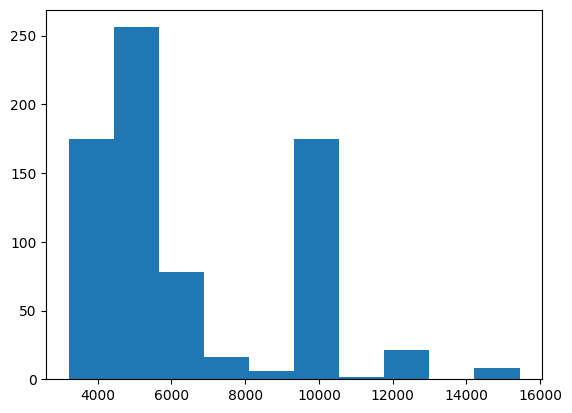

In [20]:
display(df.group_by('ZA').len().sort('ZA'))
plt.hist(df['ZA'])

YA,len
f64,u32
12143.7,11
12156.8,134
12249.6,2
12428.0,3
12576.0,146
…,…
15590.4,13
16128.0,72
17910.4,10


(array([296.,   0.,  18.,  21., 194.,  15.,  72.,   0.,   0., 121.]),
 array([12143.7 , 12772.53, 13401.36, 14030.19, 14659.02, 15287.85,
        15916.68, 16545.51, 17174.34, 17803.17, 18432.  ]),
 <BarContainer object of 10 artists>)

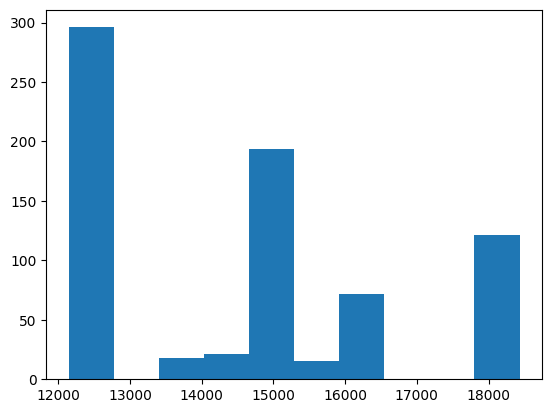

In [21]:
display(df.group_by('YA').len().sort('YA'))
plt.hist(df['YA'])

XA,len
f64,u32
12005.5,3
12156.8,174
12249.6,2
12562.9,11
12576.0,106
…,…
15590.4,85
17817.6,7
17910.4,10


(array([296.,   0.,   0., 177.,  40.,  85.,   0.,   0.,  17., 122.]),
 array([12005.5 , 12720.15, 13434.8 , 14149.45, 14864.1 , 15578.75,
        16293.4 , 17008.05, 17722.7 , 18437.35, 19152.  ]),
 <BarContainer object of 10 artists>)

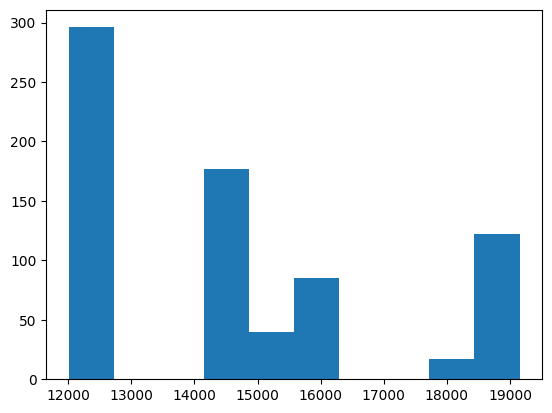

In [22]:
display(df.group_by('XA').len().sort('XA'))
plt.hist(df['XA'])

V,len
i64,u32
258355200,59
265003200,5
266985600,74
267264000,301
356352000,1
…,…
711194400,10
712704000,80
737280000,18


(array([439.,   1., 171.,   3.,   0.,  12., 108.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([2.58355200e+08, 3.33724040e+08, 4.09092880e+08, 4.84461720e+08,
        5.59830560e+08, 6.35199400e+08, 7.10568240e+08, 7.85937080e+08,
        8.61305920e+08, 9.36674760e+08, 1.01204360e+09, 1.08741244e+09,
        1.16278128e+09, 1.23815012e+09, 1.31351896e+09, 1.38888780e+09,
        1.46425664e+09, 1.53962548e+09, 1.61499432e+09, 1.69036316e+09,
        1.76573200e+09]),
 <BarContainer object of 20 artists>)

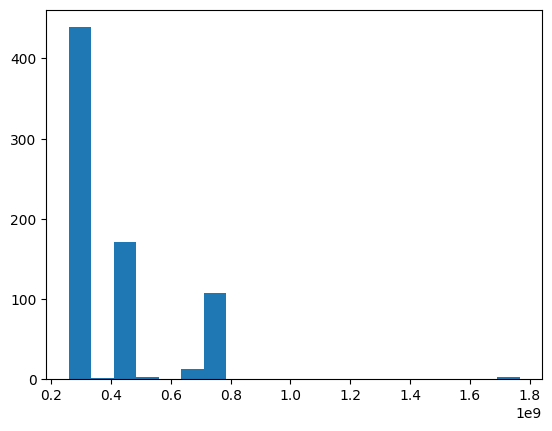

In [23]:
display(df.group_by('V').len().sort('V'))
plt.hist(df['V'], bins = 20)

(array([439.,   0.,   0.,   0.,   1.,   0.,   0., 171.,   0.,   0.,   1.,
          2.,   0.,   0.,   0.,   0.,   0.,  12.,  90.,  18.]),
 array([2.5835520e+08, 2.8230144e+08, 3.0624768e+08, 3.3019392e+08,
        3.5414016e+08, 3.7808640e+08, 4.0203264e+08, 4.2597888e+08,
        4.4992512e+08, 4.7387136e+08, 4.9781760e+08, 5.2176384e+08,
        5.4571008e+08, 5.6965632e+08, 5.9360256e+08, 6.1754880e+08,
        6.4149504e+08, 6.6544128e+08, 6.8938752e+08, 7.1333376e+08,
        7.3728000e+08]),
 <BarContainer object of 20 artists>)

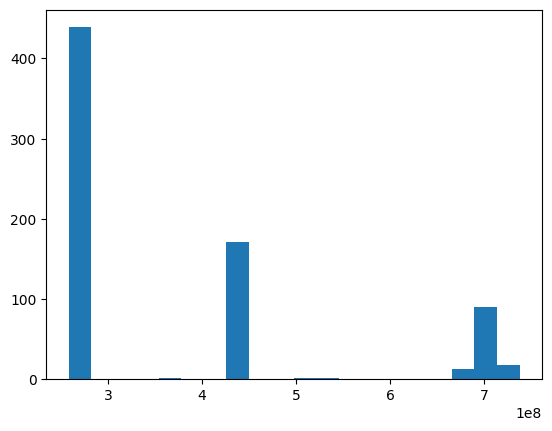

In [24]:
plt.hist(df.filter(pl.col('V') < 1.5e9)['V'], bins = 20)

### VA (Voxels in Angstrom)

VA,len
f64,u32
4.7910e11,1
4.8491e11,2
5.8081e11,25
5.9421e11,1
6.0083e11,146
…,…
2.9743e12,21
3.0956e12,1
3.3767e12,100


(array([175.,   0., 225.,  80.,   4.,  87.,  29.,   6.,   0.,   0.,   0.,
         22., 100.,   0.,   1.,   0.,   0.,   0.,   0.,   8.]),
 array([4.79095181e+11, 7.02784456e+11, 9.26473732e+11, 1.15016301e+12,
        1.37385228e+12, 1.59754156e+12, 1.82123083e+12, 2.04492011e+12,
        2.26860938e+12, 2.49229866e+12, 2.71598794e+12, 2.93967721e+12,
        3.16336649e+12, 3.38705576e+12, 3.61074504e+12, 3.83443431e+12,
        4.05812359e+12, 4.28181286e+12, 4.50550214e+12, 4.72919142e+12,
        4.95288069e+12]),
 <BarContainer object of 20 artists>)

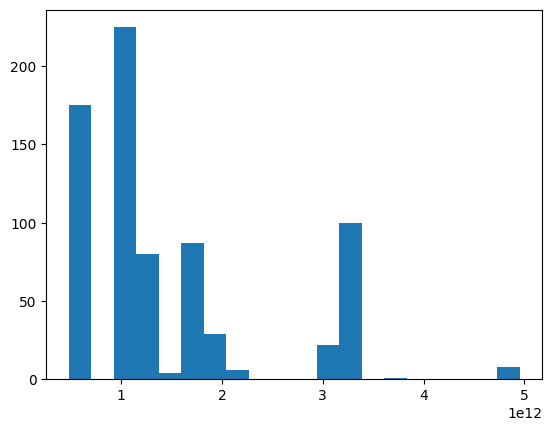

In [25]:
display(df.group_by('VA').len().sort('VA'))
plt.hist(df['VA'], bins = 20)

aspect_ratio,len
f64,u32
0.966004,3
0.966527,1
0.966667,308
0.967675,74
1.0,74
1.034483,128
1.03452,11
1.034632,120
1.40625,18


(array([386.,  74.,   0., 259.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  18.]),
 array([0.96600418, 0.98801647, 1.01002877, 1.03204106, 1.05405335,
        1.07606564, 1.09807793, 1.12009022, 1.14210251, 1.1641148 ,
        1.18612709, 1.20813938, 1.23015167, 1.25216396, 1.27417626,
        1.29618855, 1.31820084, 1.34021313, 1.36222542, 1.38423771,
        1.40625   ]),
 <BarContainer object of 20 artists>)

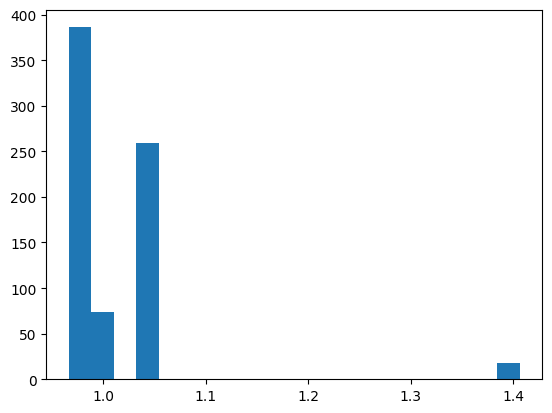

In [26]:
display(df.group_by('aspect_ratio').len().sort('aspect_ratio'))
plt.hist(df['aspect_ratio'], bins = 20)

In [27]:
df

row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors,has_motor,ZA,YA,XA,V,VA,aspect_ratio
i64,str,f64,f64,f64,i64,i64,i64,f64,i64,bool,f64,f64,f64,i64,f64,f64
0,"""tomo_003acc""",-1.0,-1.0,-1.0,500,1912,1847,6.5,0,false,3250.0,12428.0,12005.5,1765732000,4.8491e11,0.966004
1,"""tomo_00e047""",169.0,546.0,603.0,300,959,928,15.6,1,true,4680.0,14960.4,14476.8,266985600,1.0136e12,0.967675
2,"""tomo_00e463""",235.0,403.0,137.0,500,924,956,19.7,6,true,9850.0,18202.8,18833.2,441672000,3.3767e12,1.034632
3,"""tomo_00e463""",243.0,363.0,153.0,500,924,956,19.7,6,true,9850.0,18202.8,18833.2,441672000,3.3767e12,1.034632
4,"""tomo_00e463""",222.0,379.0,144.0,500,924,956,19.7,6,true,9850.0,18202.8,18833.2,441672000,3.3767e12,1.034632
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
732,"""tomo_fe050c""",138.0,134.0,542.0,300,959,928,15.6,1,true,4680.0,14960.4,14476.8,266985600,1.0136e12,0.967675
733,"""tomo_fe85f6""",-1.0,-1.0,-1.0,800,928,960,13.1,0,false,10480.0,12156.8,12576.0,712704000,1.6022e12,1.034483
734,"""tomo_fea6e8""",-1.0,-1.0,-1.0,300,960,928,16.8,0,false,5040.0,16128.0,15590.4,267264000,1.2673e12,0.966667


In [20]:
df = pl.scan_csv('/home/dangnh36/datasets/byu/raw/train_labels.csv').collect()
df = df.rename({'Motor axis 0': 'motor_z', 'Motor axis 1': 'motor_y', 'Motor axis 2': 'motor_x', 'Array shape (axis 0)': 'Z', 'Array shape (axis 1)': 'Y', 'Array shape (axis 2)': 'X',
               'Voxel spacing': 'voxel_spacing', 'Number of motors': 'ori_num_motors'}).with_columns(
    (pl.col('motor_z') >= 0).alias('has_motor')
).with_columns(
    (pl.len().over('tomo_id') * pl.col('has_motor')).alias('num_motors')
).with_columns(
    (pl.col('Z') * pl.col('voxel_spacing')).alias('ZA'),
    (pl.col('Y') * pl.col('voxel_spacing')).alias('YA'),
    (pl.col('X') * pl.col('voxel_spacing')).alias('XA'),
    (pl.col('motor_z') * pl.col('voxel_spacing')).alias('motor_zA'),
    (pl.col('motor_y') * pl.col('voxel_spacing')).alias('motor_yA'),
    (pl.col('motor_x') * pl.col('voxel_spacing')).alias('motor_xA')
).with_columns(
    (pl.col('Z') * pl.col('Y') * pl.col('X')).alias('V'),
    (pl.col('ZA') * pl.col('YA') * pl.col('XA')).alias('VA')
)


# display(df.filter(pl.col('ori_num_motors') != pl.col('num_motors')))
df

row_id,tomo_id,motor_z,motor_y,motor_x,Z,Y,X,voxel_spacing,ori_num_motors,has_motor,num_motors,ZA,YA,XA,motor_zA,motor_yA,motor_xA,V,VA
i64,str,f64,f64,f64,i64,i64,i64,f64,i64,bool,u32,f64,f64,f64,f64,f64,f64,i64,f64
0,"""tomo_003acc""",-1.0,-1.0,-1.0,500,1912,1847,6.5,0,false,0,3250.0,12428.0,12005.5,-6.5,-6.5,-6.5,1765732000,4.8491e11
1,"""tomo_00e047""",169.0,546.0,603.0,300,959,928,15.6,1,true,1,4680.0,14960.4,14476.8,2636.4,8517.6,9406.8,266985600,1.0136e12
2,"""tomo_00e463""",235.0,403.0,137.0,500,924,956,19.7,6,true,6,9850.0,18202.8,18833.2,4629.5,7939.1,2698.9,441672000,3.3767e12
3,"""tomo_00e463""",243.0,363.0,153.0,500,924,956,19.7,6,true,6,9850.0,18202.8,18833.2,4787.1,7151.1,3014.1,441672000,3.3767e12
4,"""tomo_00e463""",222.0,379.0,144.0,500,924,956,19.7,6,true,6,9850.0,18202.8,18833.2,4373.4,7466.3,2836.8,441672000,3.3767e12
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
732,"""tomo_fe050c""",138.0,134.0,542.0,300,959,928,15.6,1,true,1,4680.0,14960.4,14476.8,2152.8,2090.4,8455.2,266985600,1.0136e12
733,"""tomo_fe85f6""",-1.0,-1.0,-1.0,800,928,960,13.1,0,false,0,10480.0,12156.8,12576.0,-13.1,-13.1,-13.1,712704000,1.6022e12
734,"""tomo_fea6e8""",-1.0,-1.0,-1.0,300,960,928,16.8,0,false,0,5040.0,16128.0,15590.4,-16.8,-16.8,-16.8,267264000,1.2673e12


In [77]:
# df.write_csv('/home/dangnh36/datasets/byu/processed/gt_ori.csv')

In [21]:
df2 = df.with_columns(
    pl.concat_list(['motor_z', 'motor_y', 'motor_x']).alias('motor_zyx'),
    pl.concat_list(['motor_zA', 'motor_yA', 'motor_xA']).alias('motor_zyxA')
).group_by('tomo_id', maintain_order=True).agg(
    pl.col('Z', 'Y', 'X', 'voxel_spacing', 'ori_num_motors', 'num_motors', 'ZA', 'YA', 'XA', 'V', 'VA', 'motor_z', 'motor_y', 'motor_x', 'motor_zA', 'motor_yA', 'motor_xA').first(),
    pl.col('motor_zyx', 'motor_zyxA').map_elements(lambda x: str([e for e in x.to_list() if e[0] >= 0]), return_dtype = pl.String)
)
df2

tomo_id,Z,Y,X,voxel_spacing,ori_num_motors,num_motors,ZA,YA,XA,V,VA,motor_z,motor_y,motor_x,motor_zA,motor_yA,motor_xA,motor_zyx,motor_zyxA
str,i64,i64,i64,f64,i64,u32,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,str,str
"""tomo_003acc""",500,1912,1847,6.5,0,0,3250.0,12428.0,12005.5,1765732000,4.8491e11,-1.0,-1.0,-1.0,-6.5,-6.5,-6.5,"""[]""","""[]"""
"""tomo_00e047""",300,959,928,15.6,1,1,4680.0,14960.4,14476.8,266985600,1.0136e12,169.0,546.0,603.0,2636.4,8517.6,9406.8,"""[[169.0, 546.0, 603.0]]""","""[[2636.4, 8517.6, 9406.8]]"""
"""tomo_00e463""",500,924,956,19.7,6,6,9850.0,18202.8,18833.2,441672000,3.3767e12,235.0,403.0,137.0,4629.5,7939.1,2698.9,"""[[235.0, 403.0, 137.0], [243.0…","""[[4629.5, 7939.099999999999, 2…"
"""tomo_01a877""",300,960,928,13.1,1,1,3930.0,12576.0,12156.8,267264000,6.0083e11,147.0,638.0,286.0,1925.7,8357.8,3746.6,"""[[147.0, 638.0, 286.0]]""","""[[1925.7, 8357.8, 3746.6]]"""
"""tomo_02862f""",300,959,928,15.6,1,1,4680.0,14960.4,14476.8,266985600,1.0136e12,101.0,351.0,120.0,1575.6,5475.6,1872.0,"""[[101.0, 351.0, 120.0]]""","""[[1575.6, 5475.599999999999, 1…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""tomo_fe050c""",300,959,928,15.6,1,1,4680.0,14960.4,14476.8,266985600,1.0136e12,138.0,134.0,542.0,2152.8,2090.4,8455.2,"""[[138.0, 134.0, 542.0]]""","""[[2152.7999999999997, 2090.4, …"
"""tomo_fe85f6""",800,928,960,13.1,0,0,10480.0,12156.8,12576.0,712704000,1.6022e12,-1.0,-1.0,-1.0,-13.1,-13.1,-13.1,"""[]""","""[]"""
"""tomo_fea6e8""",300,960,928,16.8,0,0,5040.0,16128.0,15590.4,267264000,1.2673e12,-1.0,-1.0,-1.0,-16.8,-16.8,-16.8,"""[]""","""[]"""


In [22]:
df2.select(
    pl.col('tomo_id'),
    pl.col('motor_zyx', 'motor_zyxA').map_elements(lambda x: len(eval(x))) == pl.col('num_motors')
).to_numpy().all()

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


True

In [23]:
df2

tomo_id,Z,Y,X,voxel_spacing,ori_num_motors,num_motors,ZA,YA,XA,V,VA,motor_z,motor_y,motor_x,motor_zA,motor_yA,motor_xA,motor_zyx,motor_zyxA
str,i64,i64,i64,f64,i64,u32,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,str,str
"""tomo_003acc""",500,1912,1847,6.5,0,0,3250.0,12428.0,12005.5,1765732000,4.8491e11,-1.0,-1.0,-1.0,-6.5,-6.5,-6.5,"""[]""","""[]"""
"""tomo_00e047""",300,959,928,15.6,1,1,4680.0,14960.4,14476.8,266985600,1.0136e12,169.0,546.0,603.0,2636.4,8517.6,9406.8,"""[[169.0, 546.0, 603.0]]""","""[[2636.4, 8517.6, 9406.8]]"""
"""tomo_00e463""",500,924,956,19.7,6,6,9850.0,18202.8,18833.2,441672000,3.3767e12,235.0,403.0,137.0,4629.5,7939.1,2698.9,"""[[235.0, 403.0, 137.0], [243.0…","""[[4629.5, 7939.099999999999, 2…"
"""tomo_01a877""",300,960,928,13.1,1,1,3930.0,12576.0,12156.8,267264000,6.0083e11,147.0,638.0,286.0,1925.7,8357.8,3746.6,"""[[147.0, 638.0, 286.0]]""","""[[1925.7, 8357.8, 3746.6]]"""
"""tomo_02862f""",300,959,928,15.6,1,1,4680.0,14960.4,14476.8,266985600,1.0136e12,101.0,351.0,120.0,1575.6,5475.6,1872.0,"""[[101.0, 351.0, 120.0]]""","""[[1575.6, 5475.599999999999, 1…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""tomo_fe050c""",300,959,928,15.6,1,1,4680.0,14960.4,14476.8,266985600,1.0136e12,138.0,134.0,542.0,2152.8,2090.4,8455.2,"""[[138.0, 134.0, 542.0]]""","""[[2152.7999999999997, 2090.4, …"
"""tomo_fe85f6""",800,928,960,13.1,0,0,10480.0,12156.8,12576.0,712704000,1.6022e12,-1.0,-1.0,-1.0,-13.1,-13.1,-13.1,"""[]""","""[]"""
"""tomo_fea6e8""",300,960,928,16.8,0,0,5040.0,16128.0,15590.4,267264000,1.2673e12,-1.0,-1.0,-1.0,-16.8,-16.8,-16.8,"""[]""","""[]"""


In [24]:
df2.write_csv('/home/dangnh36/datasets/byu/processed/gt.csv')

In [65]:
with pl.Config(tbl_rows = 30):
    display(df['voxel_spacing'].describe(percentiles = PERCENTILES))

statistic,value
str,f64
"""count""",737.0
"""null_count""",0.0
"""mean""",15.341655
"""std""",2.398197
"""min""",6.5
"""1%""",13.1
"""5%""",13.1
"""10%""",13.1
"""25%""",13.1


In [67]:
df.filter(pl.col('voxel_spacing') < 13.1)

row_id,tomo_id,motor_z,motor_y,motor_x,Z,Y,X,voxel_spacing,ori_num_motors,has_motor,num_motors,ZA,YA,XA,motor_zA,motor_yA,motor_xA,V,VA
i64,str,f64,f64,f64,i64,i64,i64,f64,i64,bool,u32,f64,f64,f64,f64,f64,f64,i64,f64
0,"""tomo_003acc""",-1.0,-1.0,-1.0,500,1912,1847,6.5,0,false,0,3250.0,12428.0,12005.5,-6.5,-6.5,-6.5,1765732000,4.8491e11
576,"""tomo_c77de0""",-1.0,-1.0,-1.0,494,1912,1847,6.5,0,false,0,3211.0,12428.0,12005.5,-6.5,-6.5,-6.5,1744543216,4.7910e11
728,"""tomo_fc90fd""",-1.0,-1.0,-1.0,500,1912,1847,6.5,0,false,0,3250.0,12428.0,12005.5,-6.5,-6.5,-6.5,1765732000,4.8491e11


voxel_spacing,len
f64,u32
13.1,291
13.2,2
13.3,18
15.6,177
16.1,40
16.8,85
19.2,7
19.3,10
19.7,104


(array([311.,   0.,   0.,   0.,   0.,   0.,   0., 177.,   0.,  40.,   0.,
         85.,   0.,   0.,   0.,   0.,   0.,   0.,  17., 104.]),
 array([13.1 , 13.43, 13.76, 14.09, 14.42, 14.75, 15.08, 15.41, 15.74,
        16.07, 16.4 , 16.73, 17.06, 17.39, 17.72, 18.05, 18.38, 18.71,
        19.04, 19.37, 19.7 ]),
 <BarContainer object of 20 artists>)

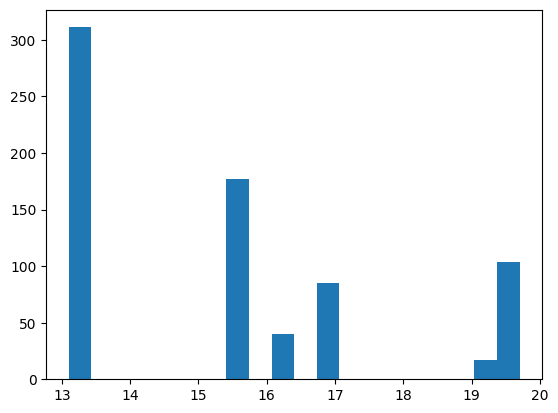

In [69]:
tmp = df.filter(pl.col('voxel_spacing') >= 13.1)
display(tmp.group_by('voxel_spacing').len().sort('voxel_spacing'))
plt.hist(tmp['voxel_spacing'], bins = 20)

In [9]:
def load_tomo(tomo_dir, start = None, end = None, step = None):
    s = slice(start, end, step)
    fnames = sorted(os.listdir(tomo_dir))
    assert fnames == [f'slice_{j:04d}.jpg' for j in range(len(fnames))]
    fnames = fnames[s]
    fpaths = [os.path.join(tomo_dir, fname) for fname in fnames]
    tomo = None
    for i, fpath in tqdm(enumerate(fpaths), total = len(fpaths)):
        if i == 0:
            img = cv2.imread(fpath, cv2.IMREAD_UNCHANGED)
            assert len(img.shape) == 2 # grayscale
            tomo = np.empty((len(fpaths), *img.shape), dtype = img.dtype) # ZYX or DHW
            tomo[0] = img
        cv2.imread(fpath, tomo[i], cv2.IMREAD_UNCHANGED)
    assert (tomo.sum(axis = (1,2)) > 0).all()
    return tomo
    
    
TRAIN_TOMO_DIR = '/home/dangnh36/datasets/byu/raw/train'
all_tomo_ids = sorted(os.listdir(TRAIN_TOMO_DIR))

i = 0
for tomo_id in tqdm(all_tomo_ids):
    tomo = load_tomo(os.path.join(TRAIN_TOMO_DIR, tomo_id))
    print(tomo.shape, tomo.dtype)
    i+=1
    if i >= 100:
        break

  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

(500, 1912, 1847) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 924, 956) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/600 [00:00<?, ?it/s]

(600, 928, 960) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 924, 956) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 1024, 1440) uint8


  0%|          | 0/800 [00:00<?, ?it/s]

(800, 928, 960) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 928, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 924, 956) uint8


  0%|          | 0/800 [00:00<?, ?it/s]

(800, 927, 959) uint8


  0%|          | 0/800 [00:00<?, ?it/s]

(800, 928, 960) uint8


  0%|          | 0/800 [00:00<?, ?it/s]

(800, 928, 960) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 924, 956) uint8


  0%|          | 0/800 [00:00<?, ?it/s]

(800, 928, 960) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 928, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/800 [00:00<?, ?it/s]

(800, 928, 960) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 928, 928) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 928, 960) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 928, 928) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 1024, 1440) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 928, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 924, 956) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 924, 956) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 924, 956) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 928, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/800 [00:00<?, ?it/s]

(800, 928, 960) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/800 [00:00<?, ?it/s]

(800, 928, 960) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 924, 956) uint8


  0%|          | 0/800 [00:00<?, ?it/s]

(800, 927, 959) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 928, 928) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 928, 960) uint8


  0%|          | 0/800 [00:00<?, ?it/s]

(800, 928, 960) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 924, 956) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 928, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 928, 960) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 928, 960) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 959, 928) uint8


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/800 [00:00<?, ?it/s]

(800, 928, 960) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 928, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 956, 924) uint8


  0%|          | 0/300 [00:00<?, ?it/s]

(300, 960, 928) uint8


In [24]:
import threading
import multiprocessing as mp
from multiprocessing import shared_memory
import math

print('CPU COUNT:', mp.cpu_count())


class ShmNdarray:
    def __init__(self, shm_name, shape, dtype, create = True):
        # should store primitive/lightweight attributes
        # so that it's easy/fast to be pickle/unpickle
        self.shm_name = shm_name
        self.shape = shape
        self.dtype = np.dtype(dtype)
        self.nbytes = math.prod(self.shape) * self.dtype.itemsize
        if create:
            shm = shared_memory.SharedMemory(name = shm_name, create=True, size=self.nbytes)
            self.shm_name = shm.name
            
    @classmethod
    def from_numpy(cls, arr, shm_name = None):
        shm = shared_memory.SharedMemory(name = shm_name, create=True, size=arr.nbytes)
        shm_name, shape, dtype = shm.name, arr.shape, arr.dtype
        # create a NumPy array backed by shared memory
        shm_arr = np.ndarray(arr.shape, dtype=arr.dtype, buffer=shm.buf)
        # Copy the original data into shared memory
        # shm_arr[:] = arr[:]
        np.copyto(shm_arr, arr)
        # shm.close()
        return cls(shm_name, shape, dtype, create = False)

    def to_numpy(self):
        shm = shared_memory.SharedMemory(self.shm_name)
        arr = np.ndarray(self.shape, dtype=self.dtype, buffer=shm.buf)
        # we need to keep at least 1 reference to this shared memory
        # as long as we access to returned numpy array
        # unless, SegmentationFault :)
        # @TODO (dangnh36): more convenient method to implement this feature
        #   - Add shm as attribute to numpy array in runtime: not easy as normal Python class since numpy implementation in C
        #   but it may be more complicated as i think with many side effects
        #   https://numpy.org/doc/stable/user/basics.subclassing.html#simple-example-adding-an-extra-attribute-to-ndarray
        #   https://stackoverflow.com/questions/67509913/add-an-attribute-to-a-numpy-array-in-runtime
        return shm, arr

    def unlink(self):
        shm = shared_memory.SharedMemory(self.shm_name)
        shm.unlink()


def _load_img_func(args):
    tomo_shm, index, fpath = args
    _shm, tomo = tomo_shm.to_numpy()
    # print(index, fpath, tomo.shape)
    cv2.imread(fpath, tomo[index], cv2.IMREAD_UNCHANGED)
    _shm.close()
    

def load_tomo_parallel(tomo_dir, start = None, end = None, step = None, pool = None):
    s = slice(start, end, step)
    fnames = sorted(os.listdir(tomo_dir))
    assert fnames == [f'slice_{j:04d}.jpg' for j in range(len(fnames))]
    fnames = fnames[s]
    fpaths = [os.path.join(tomo_dir, fname) for fname in fnames]
    img = cv2.imread(fpaths[0], cv2.IMREAD_UNCHANGED)
    assert len(img.shape) == 2 # grayscale
    tomo_shm = ShmNdarray(shm_name = None, shape = (len(fpaths), *img.shape), dtype = np.uint8, create = True)
    shm, tomo = tomo_shm.to_numpy()
    tomo[0] = img
    if pool is None:
        pool = mp.Pool(16)
    pool.map(_load_img_func, [(tomo_shm, i, fpaths[i]) for i in range(1, len(fpaths))])
    assert (tomo.sum(axis = (1,2)) > 0).all()
    tomo_shm.unlink()
    return tomo
    
    
TRAIN_TOMO_DIR = '/home/dangnh36/datasets/byu/raw/train'
all_tomo_ids = sorted(os.listdir(TRAIN_TOMO_DIR))

pool = mp.Pool(16)
# pool = None
i = 0
for tomo_id in tqdm(all_tomo_ids):
    tomo = load_tomo_parallel(os.path.join(TRAIN_TOMO_DIR, tomo_id), pool = pool)
    # print(tomo.shape, tomo.dtype)
    i+=1
    if i > 100:
        break
pool.close()

CPU COUNT: 64


  0%|          | 0/648 [00:00<?, ?it/s]

In [13]:
import threading
import multiprocessing as mp
from multiprocessing import shared_memory
import math

from multiprocessing.pool import ThreadPool

print('CPU COUNT:', mp.cpu_count())


NUM_WORKERS = 8

def _load_img_thread_func(args):
    buffer, fpath = args
    cv2.imread(fpath, buffer, cv2.IMREAD_UNCHANGED)


def load_tomo_multithread(tomo_dir, start = None, end = None, step = None, pool = None):
    s = slice(start, end, step)
    fnames = sorted(os.listdir(tomo_dir))
    assert fnames == [f'slice_{j:04d}.jpg' for j in range(len(fnames))]
    fnames = fnames[s]
    fpaths = [os.path.join(tomo_dir, fname) for fname in fnames]
    img = cv2.imread(fpaths[0], cv2.IMREAD_UNCHANGED)
    assert len(img.shape) == 2 # grayscale
    tomo = np.empty((len(fpaths), *img.shape), dtype = np.uint8)
    tomo[0] = img
    if pool is None:
        pool = mp.pool.ThreadPool(NUM_WORKERS)
    pool.map(_load_img_thread_func, [(tomo[i], fpaths[i]) for i in range(1, len(fpaths))])
    assert (tomo.sum(axis = (1,2)) > 0).all()
    return tomo
    
    
TRAIN_TOMO_DIR = '/home/dangnh36/datasets/byu/raw/train'
all_tomo_ids = sorted(os.listdir(TRAIN_TOMO_DIR))

pool = ThreadPool(NUM_WORKERS)
# pool = None
i = 0
for tomo_id in tqdm(all_tomo_ids):
    tomo = load_tomo_multithread(os.path.join(TRAIN_TOMO_DIR, tomo_id), pool = pool)
    assert tomo[-1, -1, -1] >= 0
    # print(tomo.shape, tomo.dtype)
    i+=1
    # if i > 100:
    #     break
pool.close()

CPU COUNT: 64


  0%|          | 0/648 [00:00<?, ?it/s]

#### Speedtest
- Sequential: 3p12s / 100 samples

- Multiprocess x 4 + no shared pool: 1p09/100 samples
- Multiprocess x 4 + shared pool: 1p07 / 100 samples
- Multiprocess x 8 + shared pool: 47s / 100 samples
- Multiprocess x 16 + shared pool: 35s / 100 samples


- Multithread x 4 + shared pool: 59s / 100 samples
- Multithread x 8 + shared pool: 39s / 100 samples
- Multithread x 16 + shared pool: 30s / 100 samples
- Multithread x 64 + shared pool: 25s / 100 samples
- Multithread x 64 + no shared pool: 25s / 100 samples
- Multithread x 128 + shared pool: 24s / 100 samples


# READ
- thread x 4: 14p03s
- npy: 13p41s (fast cached for about 100 samples)

#### npy file

In [58]:
for tomo_id in tqdm(all_tomo_ids):
    tomo = load_tomo_multithread(os.path.join(TRAIN_TOMO_DIR, tomo_id), pool = None)
    save_path = os.path.join(f'/home/dangnh36/datasets/byu/processed/npy/{tomo_id}.npy')
    os.makedirs(os.path.dirname(save_path), exist_ok = True)
    np.save(save_path, tomo)

  0%|          | 0/648 [00:00<?, ?it/s]

In [7]:
for tomo_id in tqdm(all_tomo_ids[:]):
    save_path = os.path.join(f'/home/dangnh36/datasets/byu/processed/npy/{tomo_id}.npy')
    tomo = np.load(save_path)
    assert tomo[-1, -1, -1] >= 0

  0%|          | 0/648 [00:00<?, ?it/s]

#### Compressed npz file

In [49]:
for tomo_id in tqdm(all_tomo_ids[:100]):
    tomo = load_tomo_multithread(os.path.join(TRAIN_TOMO_DIR, tomo_id), pool = None)
    save_path = os.path.join(f'/home/dangnh36/datasets/byu/processed/npz/{tomo_id}.npz')
    os.makedirs(os.path.dirname(save_path), exist_ok = True)
    np.savez_compressed(save_path, tomo = tomo)

  0%|          | 0/100 [00:00<?, ?it/s]

In [50]:
for tomo_id in tqdm(all_tomo_ids[:100]):
    save_path = os.path.join(f'/home/dangnh36/datasets/byu/processed/npz/{tomo_id}.npz')
    tomo = np.load(save_path)['tomo']
    assert tomo[-1, -1, -1] > 0

  0%|          | 0/100 [00:00<?, ?it/s]

#### jpg

In [48]:
# for tomo_id in tqdm(all_tomo_ids[:100]):
#     tomo = load_tomo_multithread(os.path.join(TRAIN_TOMO_DIR, tomo_id), pool = None)
#     save_path = os.path.join(f'/home/dangnh36/datasets/byu/processed/jpg/{tomo_id}.jpg')
#     os.makedirs(os.path.dirname(save_path), exist_ok = True)
#     tomo_2d = tomo.reshape(-1, tomo.shape[-1])
#     print(tomo_2d.shape)
#     cv2.imwrite(save_path, tomo_2d)
#     # cv2.imwrite(save_path, tomo[0])

In [5]:
df = pl.scan_csv('/home/dangnh36/datasets/byu/processed/gt.csv').collect()
df

tomo_id,Z,Y,X,voxel_spacing,ori_num_motors,num_motors,ZA,YA,XA,V,VA,motor_zyx,motor_zyxA
str,i64,i64,i64,f64,i64,i64,f64,f64,f64,i64,f64,str,str
"""tomo_003acc""",500,1912,1847,6.5,0,0,3250.0,12428.0,12005.5,1765732000,4.8491e11,"""[]""","""[]"""
"""tomo_00e047""",300,959,928,15.6,1,1,4680.0,14960.4,14476.8,266985600,1.0136e12,"""[[169.0, 546.0, 603.0]]""","""[[2636.4, 8517.6, 9406.8]]"""
"""tomo_00e463""",500,924,956,19.7,6,6,9850.0,18202.8,18833.2,441672000,3.3767e12,"""[[235.0, 403.0, 137.0], [243.0…","""[[4629.5, 7939.099999999999, 2…"
"""tomo_01a877""",300,960,928,13.1,1,1,3930.0,12576.0,12156.8,267264000,6.0083e11,"""[[147.0, 638.0, 286.0]]""","""[[1925.7, 8357.8, 3746.6]]"""
"""tomo_02862f""",300,959,928,15.6,1,1,4680.0,14960.4,14476.8,266985600,1.0136e12,"""[[101.0, 351.0, 120.0]]""","""[[1575.6, 5475.599999999999, 1…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""tomo_fe050c""",300,959,928,15.6,1,1,4680.0,14960.4,14476.8,266985600,1.0136e12,"""[[138.0, 134.0, 542.0]]""","""[[2152.7999999999997, 2090.4, …"
"""tomo_fe85f6""",800,928,960,13.1,0,0,10480.0,12156.8,12576.0,712704000,1.6022e12,"""[]""","""[]"""
"""tomo_fea6e8""",300,960,928,16.8,0,0,5040.0,16128.0,15590.4,267264000,1.2673e12,"""[]""","""[]"""


In [6]:
df['VA'].max()

4952880690790.4

In [7]:
# for voxel_spacing = 32, the maximum resolution is about 533 ** 3

(df['VA'].max() / (32.0 ** 3)) ** (1/3)

532.6835808062865

In [15]:
# for voxel_spacing = 32, the maximum resolution is about 245 ** 3
(df['VA'].min() / (32.0 ** 3)) ** (1/3)

244.52538747253806

In [16]:
# for voxel_spacing = 32, the maximum resolution is about 346 ** 3
(df['VA'].mean() / (32.0 ** 3)) ** (1/3)

346.0141799574342

In [8]:
# for voxel spacing = 32, the maximum resolution is 482 * 576 * 598
df.select(
    pl.col('ZA', 'YA', 'XA').max() / 32.0
)

ZA,YA,XA
f64,f64,f64
482.5,576.0,598.5


In [9]:
# for voxel spacing = 32, the minimum resolution is 100x379x375
df.select(
    pl.col('ZA', 'YA', 'XA').min() / 32.0
)

ZA,YA,XA
f64,f64,f64
100.34375,379.490625,375.171875


In [10]:
# for voxel spacing = 32, the avg resolution is 195x447x447
df.select(
    pl.col('ZA', 'YA', 'XA').mean() / 32.0
)

ZA,YA,XA
f64,f64,f64
195.033806,447.369324,447.722743


In [12]:
32 * 15

480

In [18]:
224*448*448

44957696

In [19]:
346 ** 3

41421736